<a href="https://colab.research.google.com/github/FeelOneE/Attention-is-all-you-need-pwlee/blob/main/Attention_is_all_you_need.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/ArazShilabin/english-to-german-translator-using-transformers-from-scratch/blob/main/en_de_translator.ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pwd

'/content'

In [ ]:
%cd /content/drive/MyDrive/스터디/기계이해

/content/drive/MyDrive/스터디/기계이해


# (준비) 데이터셋 및 불용어(non breaking prefix) 데이터 다운로드

In [ ]:
%cd data
!wget http://www.statmt.org/europarl/v7/de-en.tgz
!tar -xvf de-en.tgz
%cd ..

--2021-12-17 10:38:24--  http://www.statmt.org/europarl/v7/de-en.tgz
Resolving www.statmt.org (www.statmt.org)... 129.215.197.184
Connecting to www.statmt.org (www.statmt.org)|129.215.197.184|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.statmt.org/europarl/v7/de-en.tgz [following]
--2021-12-17 10:38:24--  https://www.statmt.org/europarl/v7/de-en.tgz
Connecting to www.statmt.org (www.statmt.org)|129.215.197.184|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 197785698 (189M) [application/x-gzip]
Saving to: ‘de-en.tgz’

de-en.tgz           100%[===================>] 188.62M  1.52MB/s    in 2m 4s   

2021-12-17 10:40:28 (1.52 MB/s) - ‘de-en.tgz’ saved [197785698/197785698]

europarl-v7.de-en.de
europarl-v7.de-en.en


In [ ]:
%cd data
!wget https://raw.githubusercontent.com/moses-smt/mosesdecoder/master/scripts/share/nonbreaking_prefixes/nonbreaking_prefix.de
!wget https://raw.githubusercontent.com/moses-smt/mosesdecoder/master/scripts/share/nonbreaking_prefixes/nonbreaking_prefix.en
%cd ..

--2021-12-17 10:50:33--  https://raw.githubusercontent.com/moses-smt/mosesdecoder/master/scripts/share/nonbreaking_prefixes/nonbreaking_prefix.de
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1768 (1.7K) [text/plain]
Saving to: ‘nonbreaking_prefix.de’

nonbreaking_prefix. 100%[===================>]   1.73K  --.-KB/s    in 0.003s  

2021-12-17 10:50:33 (531 KB/s) - ‘nonbreaking_prefix.de’ saved [1768/1768]

--2021-12-17 10:50:33--  https://raw.githubusercontent.com/moses-smt/mosesdecoder/master/scripts/share/nonbreaking_prefixes/nonbreaking_prefix.en
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443

In [ ]:
%cd data
%ls -al
%cd ..

/content/drive/My Drive/스터디/기계이해/data
total 2298971
-rw------- 1 root root 296468668 Dec 22 07:40 cleaning.de-en.en
-rw------- 1 root root 622086459 Dec 22 07:40 cleaning.en-de.de
-rw------- 1 root root 622086459 Dec 22 06:08 cleaning.en-de.en
-rw------- 1 root root 197785698 May 16  2012 de-en.tgz
-rw------- 1 root root 328463491 Nov 21  2011 europarl-v7.de-en.de
-rw------- 1 root root 287250069 Nov 21  2011 europarl-v7.de-en.en
-rw------- 1 root root      1768 Dec 17 10:50 nonbreaking_prefix.de
-rw------- 1 root root      1339 Dec 17 10:50 nonbreaking_prefix.en
/content/drive/My Drive/스터디/기계이해


# **step 1. 라이브러리 추가**

In [ ]:
import numpy as np
import math
import re
import time

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds

# step 2. 데이터 전처리

In [ ]:
with open("data/europarl-v7.de-en.en", mode='r', encoding="utf-8") as f:
    text_en = f.read()

with open("data/europarl-v7.de-en.de", mode='r', encoding="utf-8") as f:
    text_de = f.read()

print(text_en[:50])
print(text_de[:50])


Resumption of the session
I declare resumed the se
Wiederaufnahme der Sitzungsperiode
Ich erkläre die


In [ ]:
with open("data/nonbreaking_prefix.en", mode="r", encoding="utf-8") as f:
  non_breaking_prefix_en = f.readlines()

tmp = []
for line in non_breaking_prefix_en:
  if line[0] == "#" or line[0] == "\n" :
    pass
  else:
    tmp.append(  (line.replace("\n","")).replace("#NUMERIC_ONLY#","").strip()  )
non_breaking_prefix_en = tmp
non_breaking_prefix_en[:5]

['A', 'B', 'C', 'D', 'E']

In [ ]:
with open("data/nonbreaking_prefix.de", mode="r", encoding="utf-8") as f:
  non_breaking_prefix_de = f.readlines()

tmp = []
for line in non_breaking_prefix_de:
  if line[0] == "#" or line[0] == "\n" :
    pass
  else:
    tmp.append(  (line.replace("\n","")).replace("#NUMERIC_ONLY#","").strip()  )
non_breaking_prefix_de = tmp
non_breaking_prefix_de[:5]

['A', 'B', 'C', 'D', 'E']

In [ ]:
#non_breaking_prefix_en = non_breaking_prefix_en.split("\n")
non_breaking_prefix_en = [' ' + pref.lower() + '.' for pref in non_breaking_prefix_en]
#non_breaking_prefix_de = non_breaking_prefix_de.split("\n")
non_breaking_prefix_de = [' ' + pref.lower() + '.' for pref in non_breaking_prefix_de]
print(non_breaking_prefix_en[:5])
print(non_breaking_prefix_de[:5])

[' a.', ' b.', ' c.', ' d.', ' e.']
[' a.', ' b.', ' c.', ' d.', ' e.']


In [ ]:
for prefix in non_breaking_prefix_en:
    text_en = text_en.replace(prefix, prefix + '###')
text_en = re.sub(r"\.(?=[0-9]|[a-z]|[A-Z])", ".###", text_en)
text_en = re.sub(r"\.###", '', text_en)
text_en = re.sub(r" +", ' ', text_en)
text_en = text_en.replace('###', ' ')

text_en = text_en.split("\n")

for prefix in non_breaking_prefix_de:
    text_de = text_de.replace(prefix, prefix + '###')
text_de = re.sub(r"\.(?=[0-9]|[a-z]|[A-Z])", ".###", text_de)
text_de = re.sub(r"\.###", '', text_de)
text_de = re.sub(r" +", ' ', text_de)
text_de = text_de.replace('###', ' ')

text_de = text_de.split("\n")

In [ ]:
print(text_en[:5])
print(text_de[:5])

['Resumption of the session', 'I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.', "Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful.", 'You have requested a debate on this subject in the course of the next few days, during this part-session.', "In the meantime, I should like to observe a minute' s silence, as a number of Members have requested, on behalf of all the victims concerned, particularly those of the terrible storms, in the various countries of the European Union."]
['Wiederaufnahme der Sitzungsperiode', 'Ich erkläre die am Freitag, dem 17 Dezember unterbrochene Sitzungsperiode des Europäischen Parlaments für wiederaufgenommen, wünsche Ihnen nochmals alles Gute zum Jahreswechsel un

In [ ]:
# 전처리한 데이터 저장
with open("data/cleaning.de-en.en","w") as f:
  f.write('\n'.join(text_en))

with open("data/cleaning.en-de.de","w") as f:
  f.write('\n'.join(text_de))

In [ ]:
# 전처리한 데이터 불러오기
with open("data/cleaning.de-en.en","r+") as f:
  text_en = f.read()

with open("data/cleaning.en-de.de","r+") as f:
  text_de = f.read()

In [ ]:
print(text_en[:50])
print(text_de[:50])

Resumption of the session
I declare resumed the se
Wiederaufnahme der Sitzungsperiode
Ich erkläre die


# stop 3. 토크나이저
> 토크나이저 :  각 텍스트에 대응하는 숫자들을 이해한다. 그러므로, 우리는 어떤 텍스트를 어떤식으로 분리해서, 분리된 텍스트를 특정한 숫자(id)에 대응시키고, 해당 id를 모델의 입력으로 넣어주는 모듈.
크게 3가지 방식이 사용된다 : word-based, character-based, subword-based.

>  subword-based : word-based와 character-based 사이의 방식이다. 자주 사용되는 단어들은 subword로 분리하지 않고, 자주 등장하지 않는 단어들은 의미있는 subword로 분리하는 방법이다. 예를 들어, dogs라는 단어는 자주 사용하는 dog와 ##s 로 분리할 수 있다. 영어에서 가장 좋은 성능을 보이고 있느느 tokenizer 이다.

> "##prefix' : BERT가 사용하는 subword tokenizer인 wordpiece tokenizer에서 사용하는 방식인데, 특정 token 앞에 ##가 붙는다면 해당 token은 독립적으로 사용할 수 있는 token이 아닌, 다른 단어를 구성하는 일부라는 의미이다.



In [ ]:
!pip install transformers

In [ ]:
%tensorflow_version 2.x
from transformers import AutoTokenizer

tokenizer_en = AutoTokenizer.from_pretrained('bert-base-uncased')
tokenizer_de = AutoTokenizer.from_pretrained('GroNLP/bert-base-dutch-cased')

In [ ]:
tokenizer_en.vocab_size, tokenizer_de.vocab_size

(30522, 30073)

In [ ]:
encoded_input = tokenizer_en(text_en, return_tensors='tf')
encoded_input

Token indices sequence length is longer than the specified maximum sequence length for this model (55979209 > 512). Running this sequence through the model will result in indexing errors


{'input_ids': <tf.Tensor: shape=(1, 55979209), dtype=int32, numpy=array([[  101, 24501, 24237, ...,  1012,  1007,   102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 55979209), dtype=int32, numpy=array([[0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 55979209), dtype=int32, numpy=array([[1, 1, 1, ..., 1, 1, 1]], dtype=int32)>}

In [ ]:
encoded_output = tokenizer_de(text_de, return_tensors='tf')
encoded_output[:5] 

Token indices sequence length is longer than the specified maximum sequence length for this model (130291259 > 512). Running this sequence through the model will result in indexing errors


[Encoding(num_tokens=130291259, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])]

In [ ]:
tokenizer_en.vocab_size, tokenizer_de.vocab_size

(30522, 30073)

In [ ]:
VOCAB_SIZE_EN = tokenizer_en.vocab_size + 2
VOCAB_SIZE_DE = tokenizer_de.vocab_size + 2

# we put start and end tokens as size-1 and size-2 which are the same as
# tokenizer_size and tokenizer_size+1 because the words are from [0 to ts-1]
# tokenize_en.encode(sentence) give a list then list + list + list appends them
inputs = [[VOCAB_SIZE_EN-2] + tokenizer_en.encode(sentence) + [VOCAB_SIZE_EN-1]
          for sentence in text_en]
outputs = [[VOCAB_SIZE_DE-2] + tokenizer_de.encode(sentence) + [VOCAB_SIZE_DE-1]
          for sentence in text_de]

# step4. 모델 설계

Positional Encoding
> 트랜스포머는 RNN이 없기 때문에 위치에 대한 정보를 주입해야 한다.
> 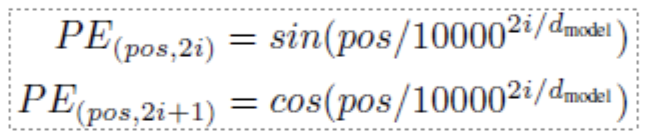


In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])

    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    angle_rads = np.zeros(angle_rads.shape)
    angle_rads[:, 0::2] = sines
    angle_rads[:, 1::2] = cosines
    pos_encoding = tf.constant(angle_rads)
    pos_encoding = pos_encoding[tf.newaxis, ...]

    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

Attention

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
  # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
  # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
  # padding_mask : (batch_size, 1, 1, key의 문장 길이)

  # Q와 K의 곱. 어텐션 스코어 행렬.
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 스케일링
  # dk의 루트값으로 나눠준다.
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
  # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
  if mask is not None:
    logits += (mask * -1e9)

  # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
  # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  output = tf.matmul(attention_weights, value)

  return output, attention_weights

In [ ]:
import numpy as np
import torch as T

  

In [ ]:
lists = [1,2,3,4]
lists[-1]

4

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    # 가정 설정문, 뒤에 조건이 일치하지 않으면 에러
    assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값.
    # 논문 기준 : 64
    self.depth = d_model // self.num_heads

    # WQ, WK, WV에 해당하는 밀집층 정의
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # WO에 해당하는 밀집층 정의
    self.dense = tf.keras.layers.Dense(units=d_model)

  # num_heads 개수만큼 q, k, v를 split하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # 1. WQ, WK, WV에 해당하는 밀집층 지나기
    # q : (batch_size, query의 문장 길이, d_model)
    # k : (batch_size, key의 문장 길이, d_model)
    # v : (batch_size, value의 문장 길이, d_model)
    # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 2. 헤드 나누기
    # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
    # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 4. 헤드 연결(concatenate)하기
    # (batch_size, query의 문장 길이, d_model)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 5. WO에 해당하는 밀집층 지나기
    # (batch_size, query의 문장 길이, d_model)
    outputs = self.dense(concat_attention)

    return outputs

In [ ]:
def split_heads(inputs, batch_size):
  inputs = tf.reshape(
      inputs, shape=(batch_size, -1, num_heads, depth))
  return tf.transpose(inputs, perm=[0, 2, 1, 3])
tmp = tf.constant([1, 2, 3, 4, 5, 6], [7,8,9,10,11,12])
split_head()

In [ ]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
import numpy as np

b = tf.convert_to_tensor(np.random.randint(0,2,size=(2,3,2,3)))
b


<tf.Tensor: shape=(2, 3, 2, 3), dtype=int64, numpy=
array([[[[1, 0, 1],
         [0, 1, 0]],

        [[0, 0, 1],
         [1, 0, 1]],

        [[1, 1, 0],
         [0, 1, 0]]],


       [[[0, 1, 0],
         [1, 0, 0]],

        [[0, 0, 0],
         [1, 1, 1]],

        [[1, 0, 1],
         [0, 0, 1]]]])>

In [ ]:
tf.shape(b)[0]

<tf.Tensor: shape=(), dtype=int32, numpy=2>